In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Load the stock data
data = pd.read_csv("all_stock_data.csv")

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date column to datetime
# Filter the last 5 years
last_5_years = datetime.now().year - 5
data = data[data['Date'].dt.year >= last_5_years]

# Specify the desired Ticker symbol (e.g., "AAPL" for Apple)
selected_ticker = ["AAPL", "CMG", "SBUX"]
ticker_data = []
for t in selected_ticker:
    # Filter the data for the specified Ticker
    tick_data = data[data['Ticker'] == t].copy()
    # Reset the index after filtering
    tick_data.reset_index(drop=True, inplace=True)

    # Calculate target variable: change in Open/Close
    tick_data['Change'] = ((tick_data['Close'] - tick_data['Open']) / tick_data['Open'] * 100).round(2)
    # Shift the change vector by 1 to make features project into next week
    tick_data['Next Change'] = tick_data['Change'].shift(-1)
    # Drop any rows with NaN values (will occur on last row due to shifting)
    tick_data = tick_data.dropna()

    # Drop unnecessary columns
    features = ['Open', 'Close', 'High', 'Low', 'Volume']
    tick_data = tick_data[features + ['Next Change']].dropna()
    tick_data.dropna()
    ticker_data.append(tick_data)

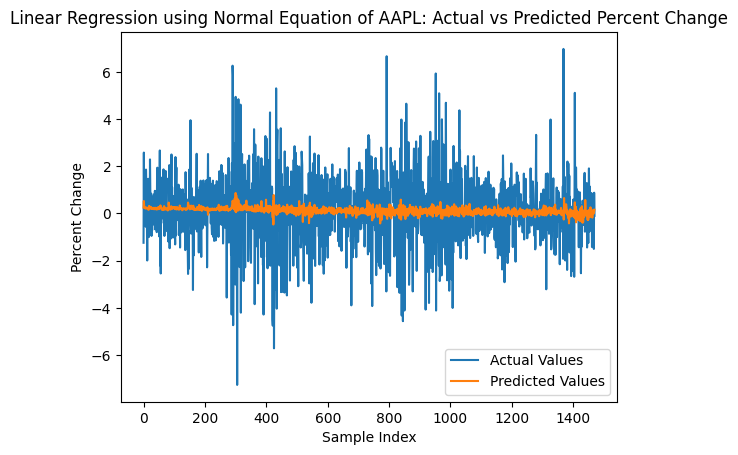

Linear Regression using Normal Equation MSE for AAPL: 2.1689987578151206

Thetas for AAPL: [ 1.46170679e-01 -8.79441851e-02 -1.29795670e-01  9.61582557e-02
  1.20976297e-01  9.96535229e-10]


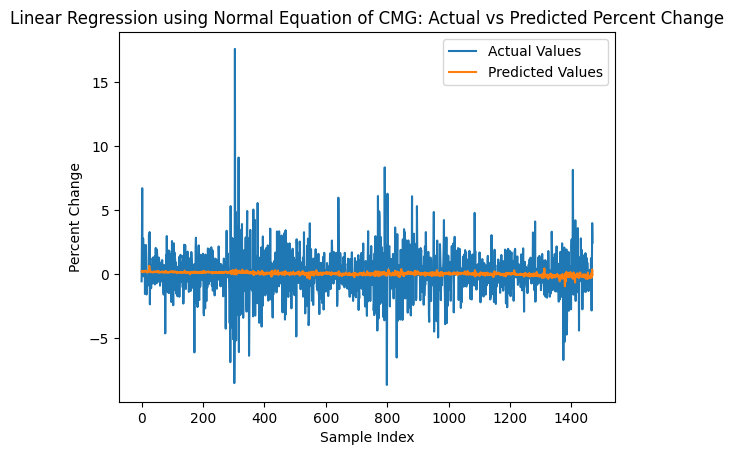

Linear Regression using Normal Equation MSE for CMG: 3.115001936469836

Thetas for CMG: [ 1.93064489e-01 -2.88610648e-01 -3.47072948e-01  3.15420621e-01
  3.14586138e-01  1.90624770e-09]


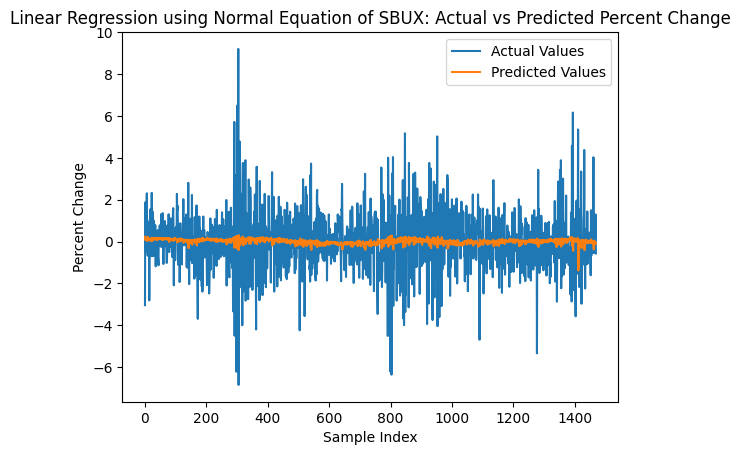

Linear Regression using Normal Equation MSE for SBUX: 1.9434482163368245

Thetas for SBUX: [ 5.64424843e-01  3.29642685e-02 -9.49396704e-02  1.13960141e-02
  4.54572104e-02 -6.60283497e-09]


In [2]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]

    # 1. Linear Regression using Normal Equation
    X = np.c_[np.ones((X.shape[0], 1)), X]
    theta_linear = np.linalg.inv(X.T @ X) @ X.T @ y

    # Predictions on the training set
    y_pred = X @ theta_linear

    # Plot predictions
    plt.plot(range(len(y)), y, label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Linear Regression using Normal Equation of {name}: Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()

    mse = mean_squared_error(y, y_pred)
    print(f"Linear Regression using Normal Equation MSE for {name}: {mse}")
    print(f"\nThetas for {name}: {theta_linear}")
    i += 1


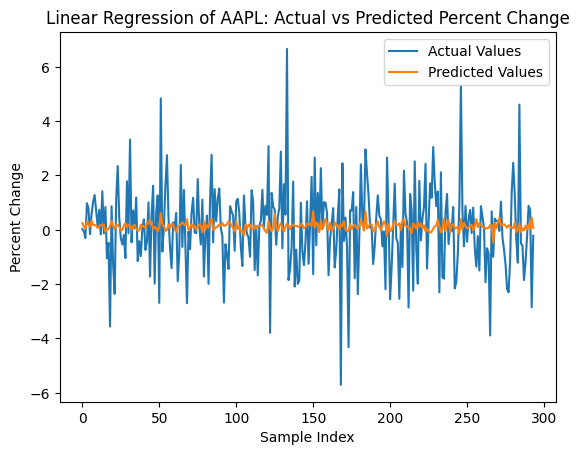

Linear Regression MSE for AAPL: 2.305506688382206


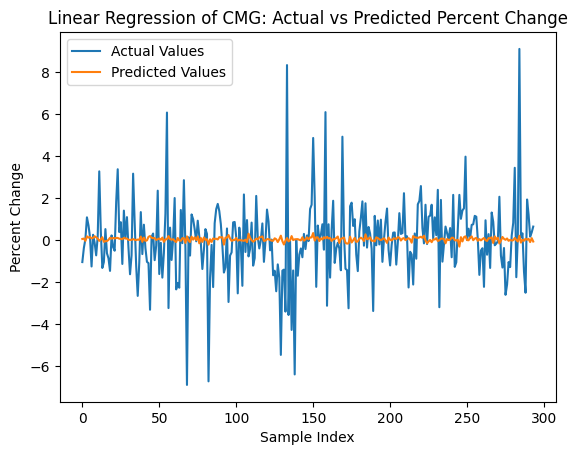

Linear Regression MSE for CMG: 3.275972865569313


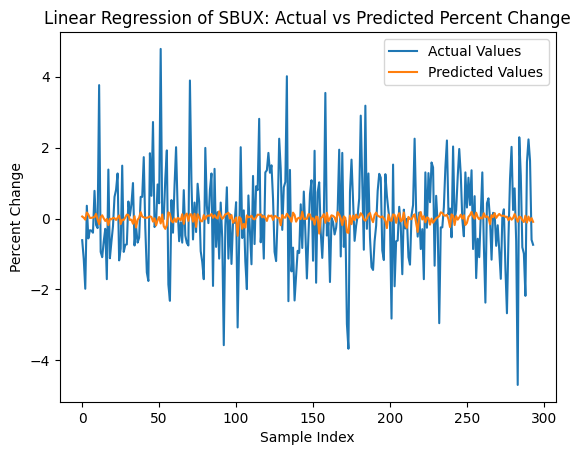

Linear Regression MSE for SBUX: 1.7598852994122811


In [3]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Traditional Statistical Model - Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    linear_preds = linear_model.predict(X_test)

    # Plot predictions
    plt.plot(range(len(y_test)), y_test, label="Actual Values")
    plt.plot(range(len(linear_preds)), linear_preds, label="Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Linear Regression of {name}: Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()

    mse_lr = mean_squared_error(y_test, linear_preds)
    print(f"Linear Regression MSE for {name}: {mse_lr}")
    i += 1

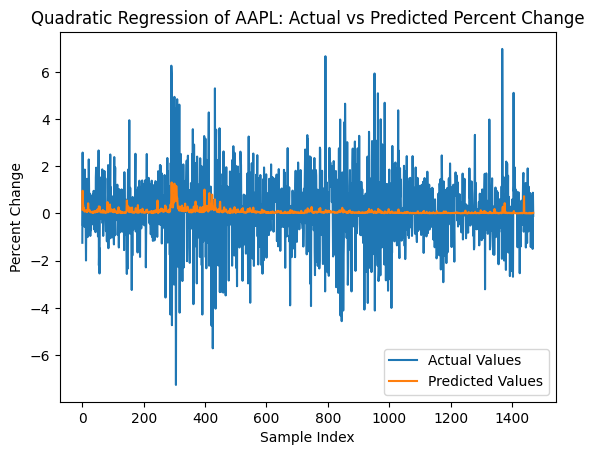

Quadratic Regression MSE for AAPL: 2.1814080734900654

Thetas for AAPL: [1.99472328e-34 2.08531997e-32 2.11069388e-32 2.14325313e-32
 2.07709748e-32 3.31354593e-26 2.68854360e-30 2.69175572e-30
 2.77078767e-30 2.61141194e-30 7.22418942e-18]


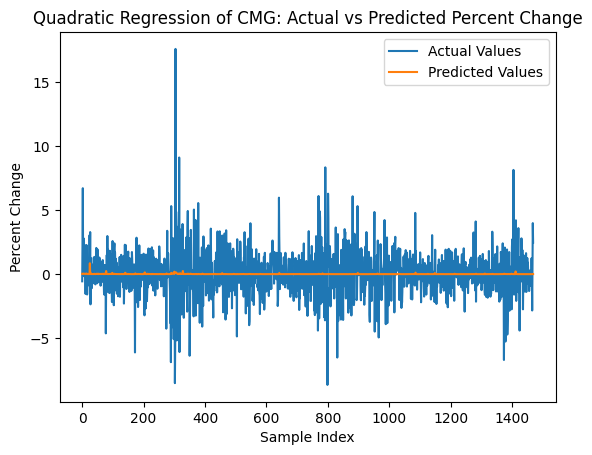

Quadratic Regression MSE for CMG: 3.1315473164124596

Thetas for CMG: [3.24649540e-33 7.53661574e-32 7.45204876e-32 7.58687669e-32
 7.28469439e-32 1.72110991e-25 2.28881455e-30 2.29750207e-30
 2.37508255e-30 2.20034199e-30 1.78641578e-17]


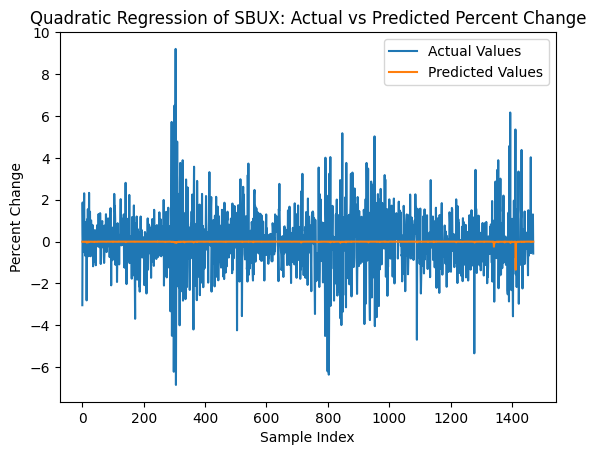

Quadratic Regression MSE for SBUX: 1.9548982294636652

Thetas for SBUX: [-1.26561069e-32 -1.08699176e-30 -1.09445289e-30 -1.10813078e-30
 -1.06901403e-30 -4.85590929e-25 -9.54320839e-29 -9.71271557e-29
 -9.94323599e-29 -9.27181703e-29 -5.43930629e-17]


In [4]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]
    
    # Create quadratic features
    X_quad = np.hstack([X, X**2])
    X_quad = np.c_[np.ones((X_quad.shape[0], 1)), X_quad]
    theta_quad = np.linalg.pinv(X_quad.T @ X_quad) @ X_quad.T @ y

    # Predictions on the training set
    y_pred = X_quad @ theta_quad

    # Plot predictions
    plt.plot(range(len(y)), y, label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Quadratic Regression of {name}: Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()

    # Get Error
    mse = mean_squared_error(y, y_pred)
    print(f"Quadratic Regression MSE for {name}: {mse}")
    print(f"\nThetas for {name}: {theta_quad}")
    i += 1

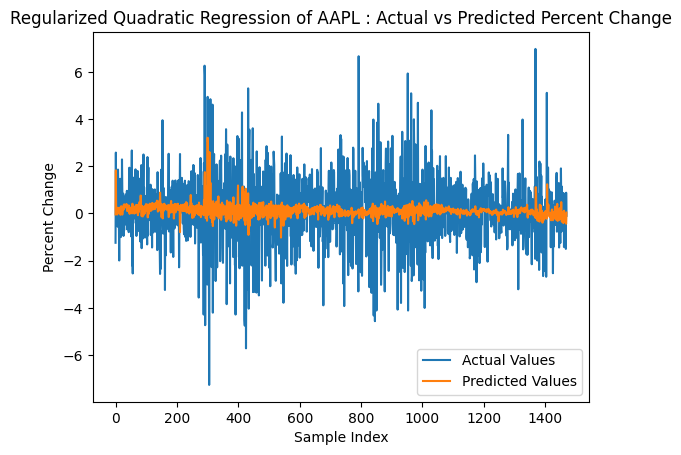

Regularized Quadratic Regression MSE for AAPL: 2.1285378778122954
Thetas for AAPL : [ 7.49307821e-01 -1.32568457e-01 -6.56279007e-01  1.99443455e-01
  5.94285678e-01 -8.72621744e-09  2.03673775e-04  1.74037438e-03
 -3.26746698e-04 -1.65631726e-03  3.04728476e-17]


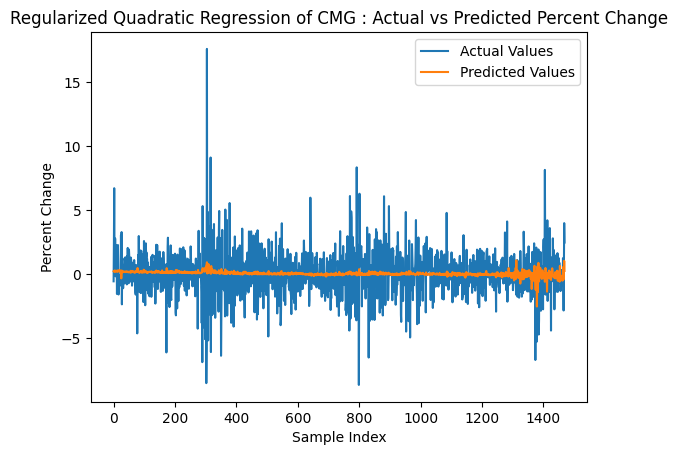

Regularized Quadratic Regression MSE for CMG: 3.097438000621018
Thetas for CMG : [ 3.28041034e-01  9.21855074e-01  4.34605438e-01 -5.52569752e-01
 -8.23608854e-01  2.56918634e-09 -1.50753934e-02 -9.85871725e-03
  1.09115363e-02  1.42707106e-02 -1.87725862e-17]


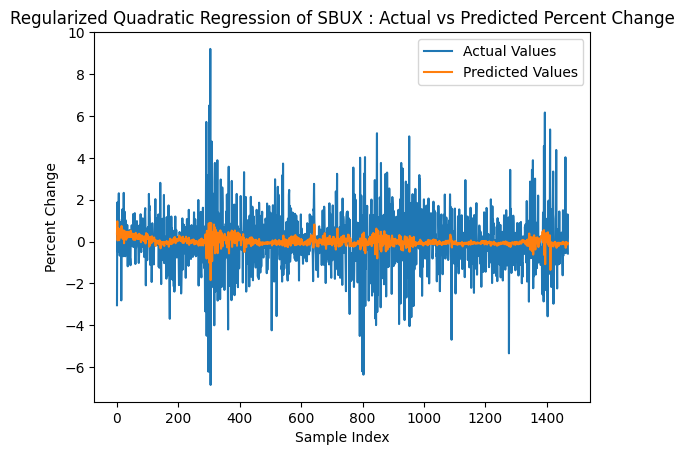

Regularized Quadratic Regression MSE for SBUX: 1.9148784724441457
Thetas for SBUX : [ 4.37818702e+00  1.12058469e+00 -4.06749509e-01 -6.66378761e-01
 -1.31731083e-01 -1.05837817e-08 -5.91396077e-03  1.74677605e-03
  3.72476564e-03  8.42307589e-04  2.19871691e-17]


In [5]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]
    
    # Create quadratic features
    X_quad = np.hstack([X, X**2])
    X_quad = np.c_[np.ones((X_quad.shape[0], 1)), X_quad]
    theta_quad = np.linalg.pinv(X_quad.T @ X_quad) @ X_quad.T @ y

    # Add a small regularization term to the diagonal
    lambda_identity = 1e-5 * np.eye(X_quad.shape[1])  # Adjust lambda as needed
    theta_quad = np.linalg.inv(X_quad.T @ X_quad + lambda_identity) @ X_quad.T @ y

    # Predictions on the training set
    y_pred = X_quad @ theta_quad

    # Plot predictions
    plt.plot(range(len(y)), y, label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Regularized Quadratic Regression of {name} : Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()

    # Get Error
    mse = mean_squared_error(y, y_pred)
    print(f"Regularized Quadratic Regression MSE for {name}: {mse}")
    print(f"Thetas for {name} : {theta_quad}")
    i += 1

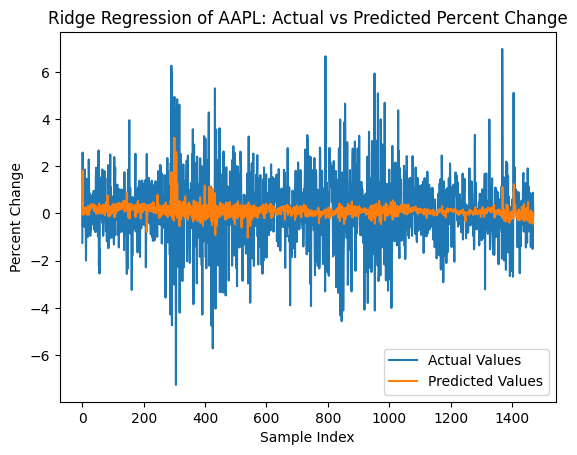

Ridge Regression MSE for AAPL: 2.1285378778122954
Thetas for AAPL : [ 7.49307821e-01 -1.32568457e-01 -6.56279007e-01  1.99443455e-01
  5.94285678e-01 -8.72621744e-09  2.03673775e-04  1.74037438e-03
 -3.26746698e-04 -1.65631726e-03  3.04728476e-17]


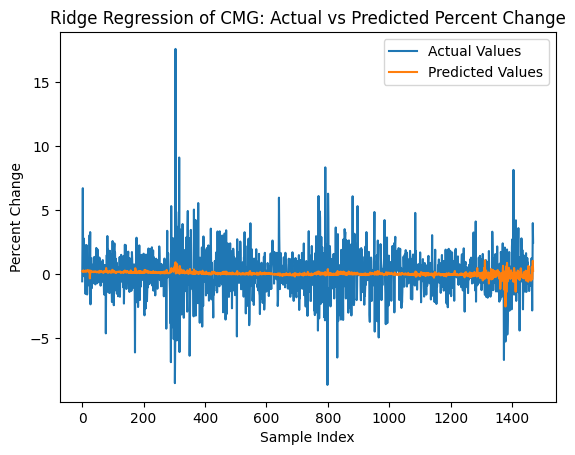

Ridge Regression MSE for CMG: 3.097438000621018
Thetas for CMG : [ 3.28041034e-01  9.21855074e-01  4.34605438e-01 -5.52569752e-01
 -8.23608854e-01  2.56918634e-09 -1.50753934e-02 -9.85871725e-03
  1.09115363e-02  1.42707106e-02 -1.87725862e-17]


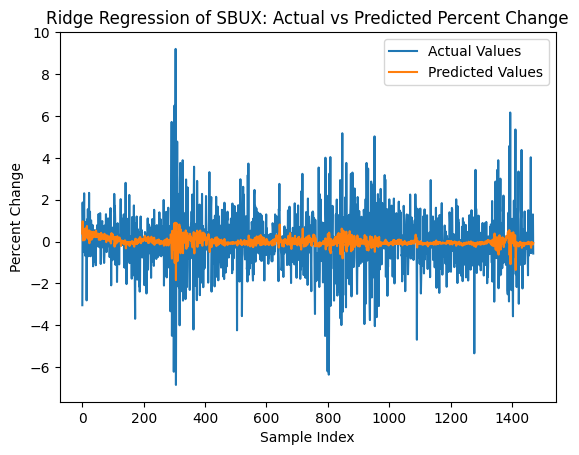

Ridge Regression MSE for SBUX: 1.9148784724441457
Thetas for SBUX : [ 4.37818702e+00  1.12058469e+00 -4.06749509e-01 -6.66378761e-01
 -1.31731083e-01 -1.05837817e-08 -5.91396077e-03  1.74677605e-03
  3.72476564e-03  8.42307589e-04  2.19871691e-17]


In [6]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]
    
    # Create quadratic features
    X_quad = np.hstack([X, X**2])
    X_quad = np.c_[np.ones((X_quad.shape[0], 1)), X_quad]
    theta_quad = np.linalg.pinv(X_quad.T @ X_quad) @ X_quad.T @ y

    # Add a small regularization term to the diagonal
    lambda_identity = 1e-5 * np.eye(X_quad.shape[1])  # Adjust lambda as needed
    theta_quad = np.linalg.inv(X_quad.T @ X_quad + lambda_identity) @ X_quad.T @ y
    
    # Ridge Regression
    lambda_identity = 1e-5 * np.eye(X_quad.shape[1])
    theta_quad = np.linalg.inv(X_quad.T @ X_quad + lambda_identity) @ X_quad.T @ y

    # Predictions on the training set
    y_pred = X_quad @ theta_quad

    # Plot predictions
    plt.plot(range(len(y)), y, label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Ridge Regression of {name}: Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()
    
    # Get Error
    mse = mean_squared_error(y, y_pred)
    print(f"Ridge Regression MSE for {name}: {mse}")
    print(f"Thetas for {name} : {theta_quad}")
    i += 1

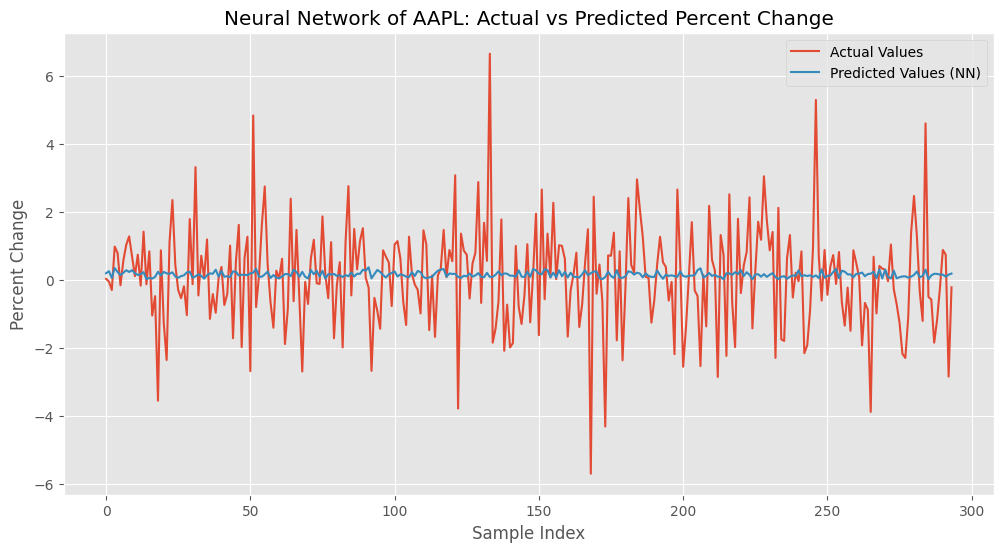

Cross-Validation MSE Scores for AAPL: [1.96583752 2.38390546 2.68673714 2.07735077 2.06325036 1.88543328
 1.61635298 1.90753342 2.82534008 2.65222519]
Mean CV MSE for AAPL: 2.206396622065494
Test Set MSE for AAPL: 2.314292626021132


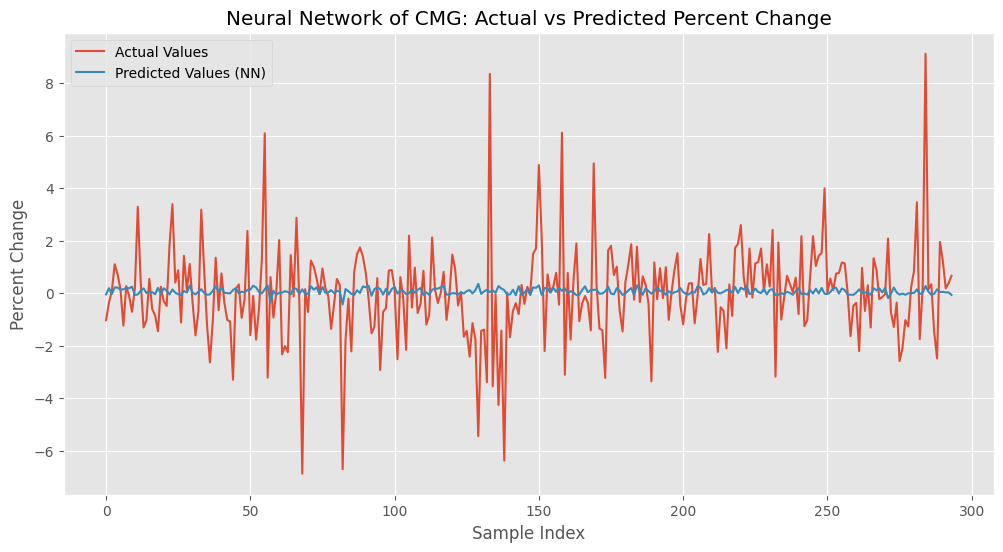

Cross-Validation MSE Scores for CMG: [2.1679044  3.07474551 3.76728781 2.58084994 2.98389844 2.2304289
 2.6496641  5.36995665 3.13770921 3.2208876 ]
Mean CV MSE for CMG: 3.118333254691394
Test Set MSE for CMG: 3.2735713110424345


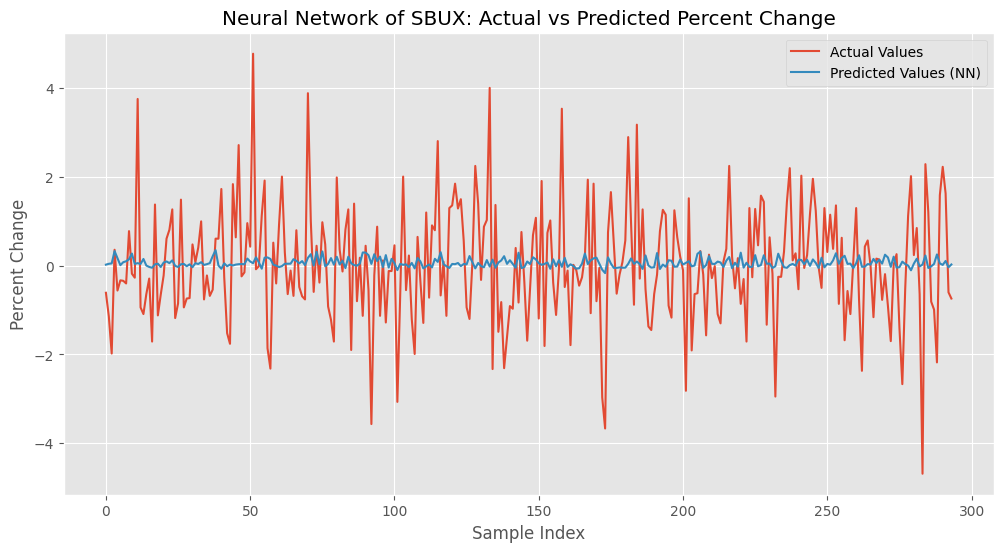

Cross-Validation MSE Scores for SBUX: [1.30247841 2.40814755 2.95599006 1.62394154 2.16776699 1.37558154
 1.49414814 2.5801402  1.96589598 2.50312499]
Mean CV MSE for SBUX: 2.0377215392071886
Test Set MSE for SBUX: 1.75759829655071


In [7]:
i = 0
for d in ticker_data:
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Change'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #Neural Network model
    plt.style.use('ggplot')
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize the neural network
    model = MLPRegressor( hidden_layer_sizes=(64, 32), activation='relu', solver='adam', 
        max_iter=10000,
        early_stopping=True,
        random_state=42)

    # Fit the model and evaluate on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values (NN)")
    plt.xlabel("Sample Index")
    plt.ylabel("Percent Change")
    plt.title(f"Neural Network of {name}: Actual vs Predicted Percent Change")
    plt.legend()
    plt.show()

    # Perform cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    cv_scores = -cv_scores  # Convert negative MSE to positive
    mean_cv_score = np.mean(cv_scores)
    print(f"Cross-Validation MSE Scores for {name}: {cv_scores}")
    print(f"Mean CV MSE for {name}: {mean_cv_score}")
    
    mse_test = mean_squared_error(y_test, y_pred)
    print(f"Test Set MSE for {name}: {mse_test}")
    i += 1